$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 2: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

Let's begin by downloading a dataset of images that we want to learn to generate. 
We'll use the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW) dataset which contains many labeled faces of famous individuals.

We're going to train our generative model to generate a specific face, not just any face.
Since the person with the most images in this dataset is former president George W. Bush, we'll set out to train a Bush Generator :)

However, if you feel adventurous and/or prefer to generate something else, feel free to edit the `PART2_CUSTOM_DATA_URL` variable in `hw3/answers.py`.


You can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`, and get a bonus!

In [2]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File C:\Users\shayr\.pytorch-datasets\pokemon_data.zip exists, skipping download.
Extracting C:\Users\shayr\.pytorch-datasets\pokemon_data.zip...
Extracted 2883 to C:\Users\shayr\.pytorch-datasets\pokemon_data/archive


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 2780 images in dataset folder.


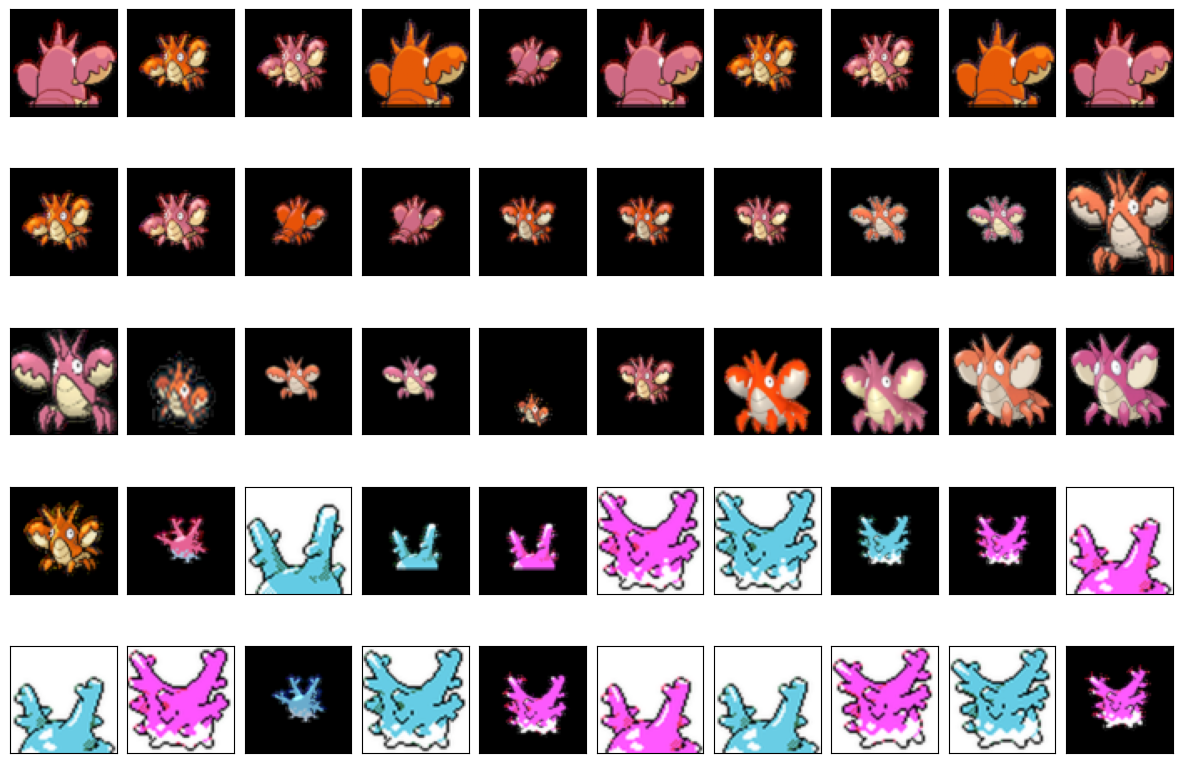

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (fc): Linear(in_features=16384, out_features=1, bias=True)
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=16384, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(1024, 4, 4))
  )
  (cnn): Sequential(
    (0): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
    (2): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), 

### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)


tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

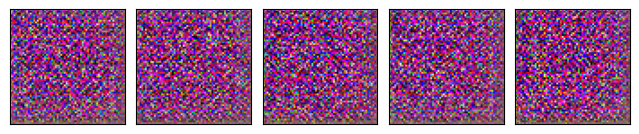

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [25]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'h_dim': 0, 'z_dim': 4, 'x_sigma2': 0, 'learn_rate': 0.0, 'betas': (0.0, 0.0), 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.999)}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████| 87/87 [00:30<00:00,  2.84it/s]
Discriminator loss: 1.1875602116529969
Generator loss:     2.3668155670166016
Saved checkpoint.


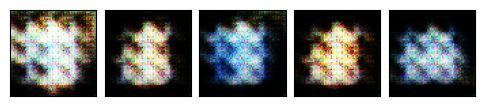

--- EPOCH 2/100 ---
100%|██████████| 87/87 [00:30<00:00,  2.87it/s]
Discriminator loss: 1.2379519603718285
Generator loss:     2.1005995150270134
Saved checkpoint.


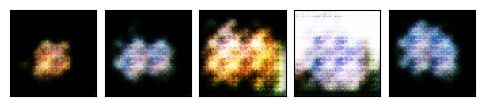

--- EPOCH 3/100 ---
100%|██████████| 87/87 [00:30<00:00,  2.87it/s]
Discriminator loss: 1.2146615386009216
Generator loss:     1.919444486327555
Saved checkpoint.


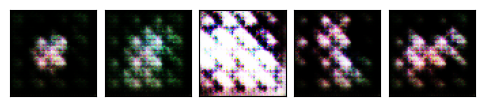

--- EPOCH 4/100 ---
100%|██████████| 87/87 [00:30<00:00,  2.89it/s]
Discriminator loss: 1.1384894101099037
Generator loss:     1.9057107355402805
Saved checkpoint.


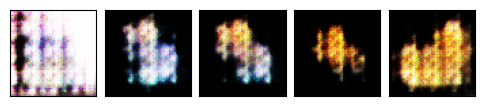

--- EPOCH 5/100 ---
100%|██████████| 87/87 [00:30<00:00,  2.88it/s]
Discriminator loss: 1.1639767618014896
Generator loss:     1.9459056326712685


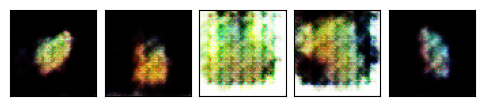

--- EPOCH 6/100 ---
100%|██████████| 87/87 [00:30<00:00,  2.89it/s]
Discriminator loss: 1.1488402294016433
Generator loss:     1.9559596482364612


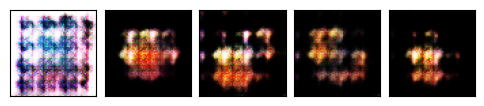

--- EPOCH 7/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 1.124513543200219
Generator loss:     2.057678242524465


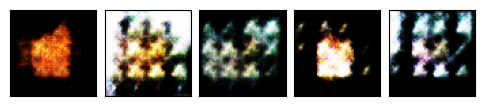

--- EPOCH 8/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 1.1162301055316268
Generator loss:     2.179433887032257


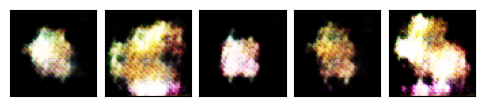

--- EPOCH 9/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 1.1046161415248081
Generator loss:     2.5330625978009453


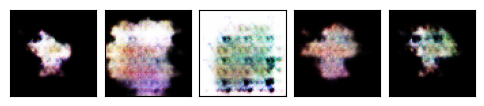

--- EPOCH 10/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 1.1016843284683666
Generator loss:     2.4795775022999993


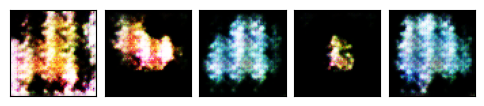

--- EPOCH 11/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 1.047224179766644
Generator loss:     2.695986425739595


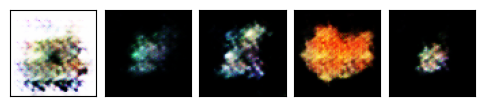

--- EPOCH 12/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.9966792820513933
Generator loss:     2.9158199950196275


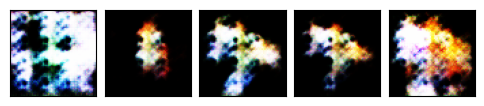

--- EPOCH 13/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.9080838687803553
Generator loss:     3.1397921682774337


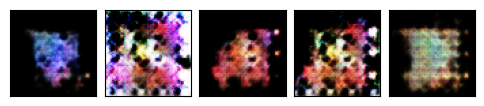

--- EPOCH 14/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 1.0459315550738368
Generator loss:     2.601599288397822


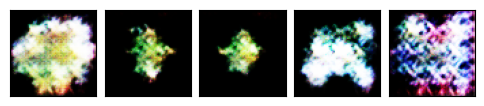

--- EPOCH 15/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.9985684622293232
Generator loss:     2.9185318672794036


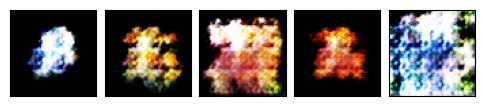

--- EPOCH 16/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.8361852996308228
Generator loss:     3.5003694597331956


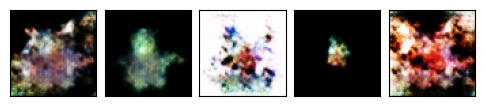

--- EPOCH 17/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.8311914938619767
Generator loss:     3.4531283984924186


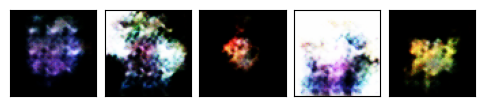

--- EPOCH 18/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.7951361321597948
Generator loss:     3.7145257105772522


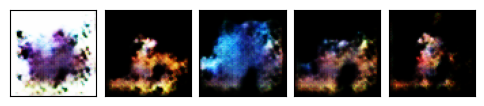

--- EPOCH 19/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.7672323876585083
Generator loss:     3.439506763699411


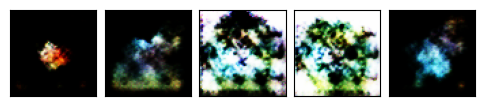

--- EPOCH 20/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.97it/s]
Discriminator loss: 0.7351647292574247
Generator loss:     3.674631782646837


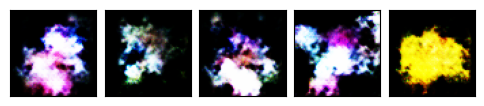

--- EPOCH 21/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.6396179815390329
Generator loss:     4.072269663728517


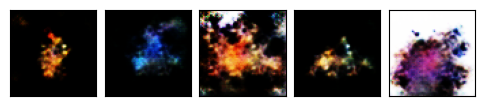

--- EPOCH 22/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.6768018085637997
Generator loss:     4.284753314379988


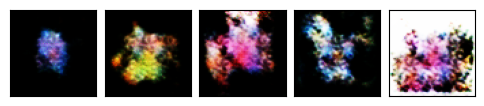

--- EPOCH 23/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.7355583849223866
Generator loss:     3.9222291105094995


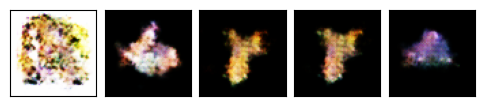

--- EPOCH 24/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.97it/s]
Discriminator loss: 0.7962520326348557
Generator loss:     3.744184887272188


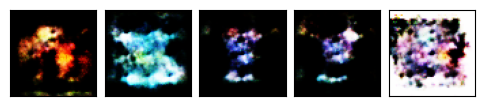

--- EPOCH 25/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.91it/s]
Discriminator loss: 0.6098985016859811
Generator loss:     4.286318530296457


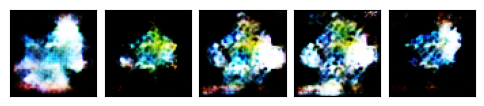

--- EPOCH 26/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.560235041268598
Generator loss:     4.74818657732558


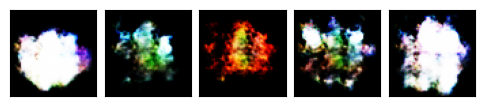

--- EPOCH 27/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.97it/s]
Discriminator loss: 0.5475524577429924
Generator loss:     4.605682027751002


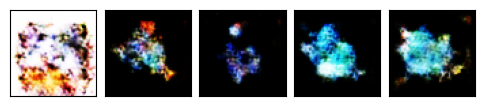

--- EPOCH 28/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.5468942678223053
Generator loss:     4.828009893154276


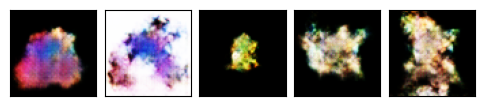

--- EPOCH 29/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.5197035210399792
Generator loss:     4.667297133084001


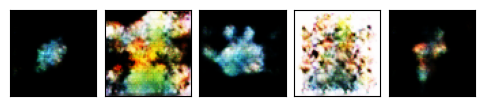

--- EPOCH 30/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.6047744252558412
Generator loss:     4.466633596639523


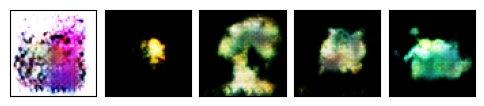

--- EPOCH 31/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.5003187765592131
Generator loss:     5.427772179417227


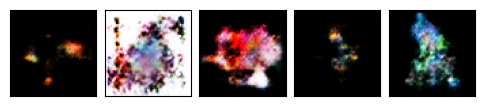

--- EPOCH 32/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.4212179660968397
Generator loss:     5.426993325523947


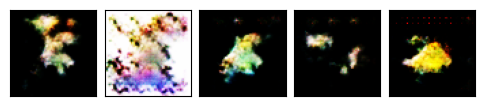

--- EPOCH 33/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.5378731945850725
Generator loss:     4.968415239761615


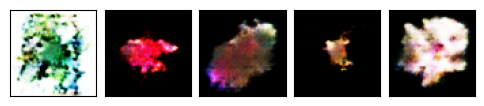

--- EPOCH 34/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.5069733882515595
Generator loss:     5.125015128617999


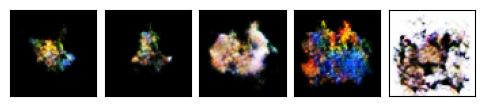

--- EPOCH 35/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.48525629556555855
Generator loss:     5.31064346192897


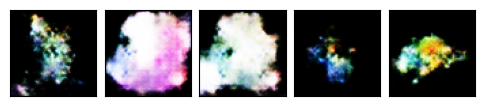

--- EPOCH 36/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.4459156061511958
Generator loss:     5.215347346218153


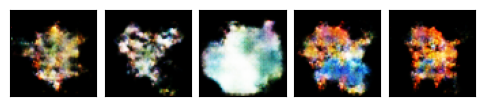

--- EPOCH 37/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.5083045883682268
Generator loss:     4.991172700092711


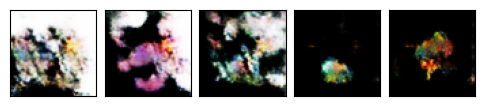

--- EPOCH 38/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.4605854631926136
Generator loss:     5.033631990695822


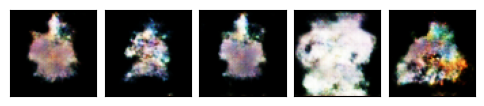

--- EPOCH 39/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.3933910674833018
Generator loss:     5.211344242095947


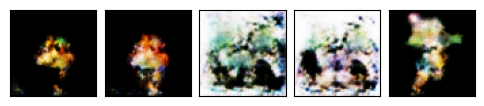

--- EPOCH 40/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.43173124474184266
Generator loss:     5.506082699901756


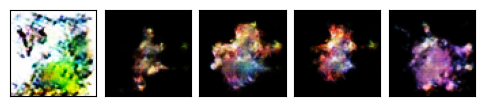

--- EPOCH 41/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.24457932659692463
Generator loss:     6.060098035582181


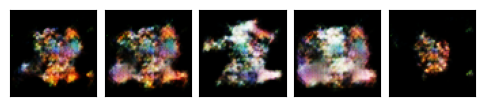

--- EPOCH 42/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.3548639677464962
Generator loss:     5.61875922104408


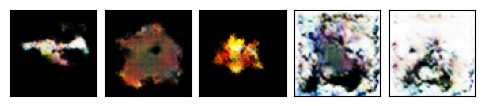

--- EPOCH 43/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.33637162625532724
Generator loss:     6.225884323147522


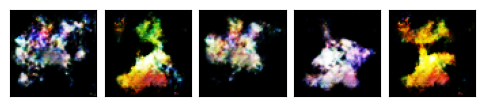

--- EPOCH 44/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.28152307228923873
Generator loss:     6.259889164190183


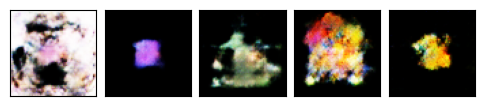

--- EPOCH 45/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.3151999933366803
Generator loss:     6.389514403781671


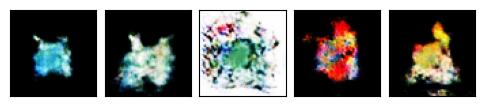

--- EPOCH 46/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.34038177261064795
Generator loss:     6.070456832304768


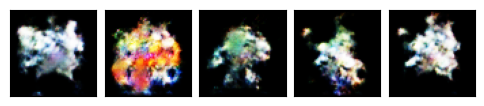

--- EPOCH 47/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.29779495799849776
Generator loss:     5.832096647942203


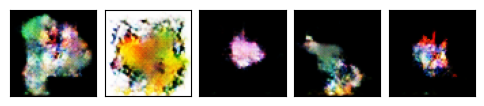

--- EPOCH 48/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.97it/s]
Discriminator loss: 0.40834006894080116
Generator loss:     6.047262783708243


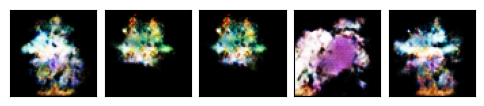

--- EPOCH 49/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.28660095744263164
Generator loss:     6.662836521521382


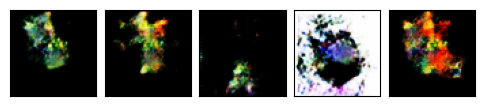

--- EPOCH 50/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.33078898917669536
Generator loss:     6.20472305807574


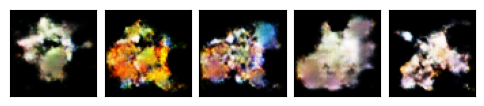

--- EPOCH 51/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.36637788244533814
Generator loss:     6.380247692952211


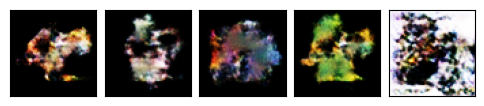

--- EPOCH 52/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.27522830102036056
Generator loss:     6.363332684697776


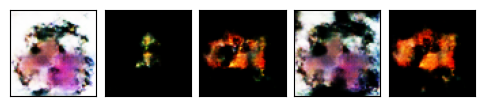

--- EPOCH 53/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.15614975860406613
Generator loss:     5.972585058760369


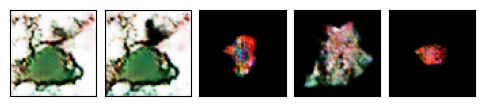

--- EPOCH 54/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.23616551335943842
Generator loss:     8.041793669777356


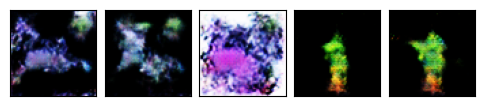

--- EPOCH 55/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.26808287653986407
Generator loss:     6.934381327409854


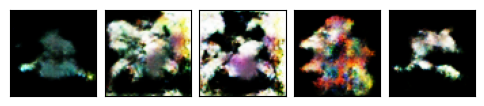

--- EPOCH 56/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.3028286320168054
Generator loss:     6.738771394751538


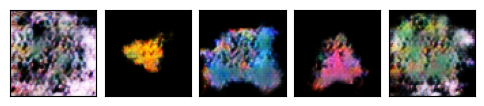

--- EPOCH 57/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.3958857338233241
Generator loss:     6.409853590973492


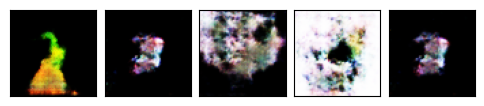

--- EPOCH 58/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.3695031713651515
Generator loss:     6.062202267263127


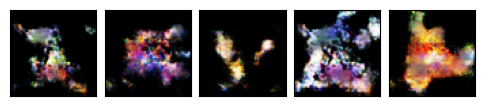

--- EPOCH 59/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.2218880862019014
Generator loss:     7.015507247256137


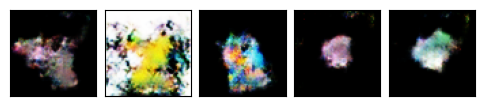

--- EPOCH 60/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.97it/s]
Discriminator loss: 0.2697946413195339
Generator loss:     6.580109881258559


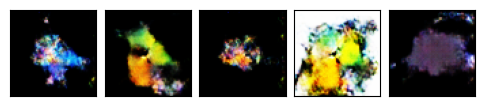

--- EPOCH 61/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.23676476019552384
Generator loss:     7.084475417246764


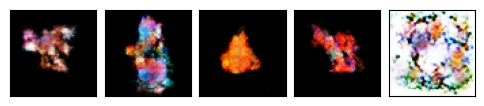

--- EPOCH 62/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.23737019822857847
Generator loss:     7.31323705699252


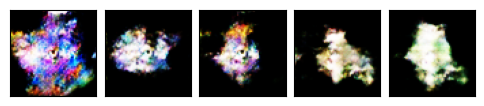

--- EPOCH 63/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.25336243235773737
Generator loss:     7.397705860521602


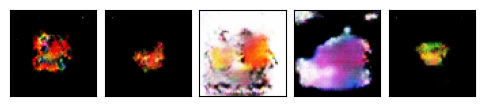

--- EPOCH 64/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.21180108011882195
Generator loss:     7.248387694358826


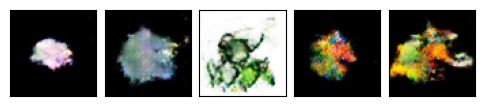

--- EPOCH 65/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.21858429885201755
Generator loss:     6.924811512574382


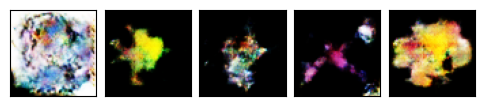

--- EPOCH 66/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.3437140056028448
Generator loss:     7.906311531861623


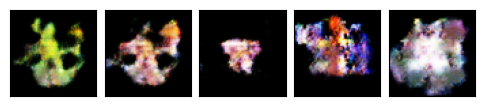

--- EPOCH 67/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.2600494831928919
Generator loss:     6.893033435974998


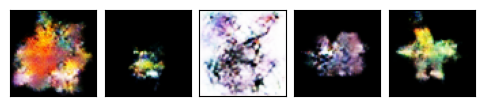

--- EPOCH 68/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.97it/s]
Discriminator loss: 0.2525510971873314
Generator loss:     7.234489164133182


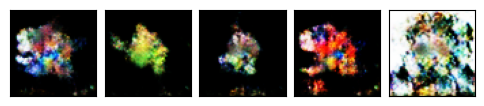

--- EPOCH 69/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.31840321995403575
Generator loss:     7.410707052411704


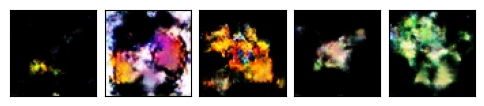

--- EPOCH 70/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.23179011644217476
Generator loss:     6.9830229535870165


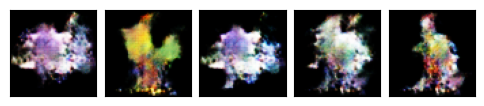

--- EPOCH 71/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.14560765713110738
Generator loss:     6.630840635847771


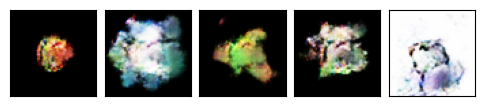

--- EPOCH 72/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.10779428787144094
Generator loss:     6.883062721668989


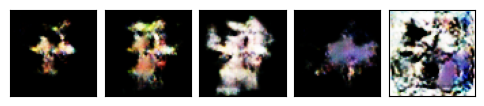

--- EPOCH 73/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.97it/s]
Discriminator loss: 0.19872656751466894
Generator loss:     8.342096002622583


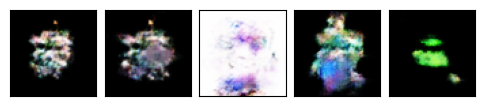

--- EPOCH 74/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.09877820342950437
Generator loss:     7.905921812715201


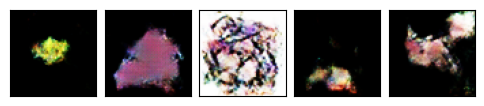

--- EPOCH 75/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.2519715827643529
Generator loss:     8.009917403432144


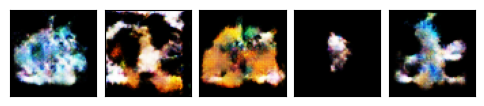

--- EPOCH 76/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.15059440938391905
Generator loss:     7.713519170366484


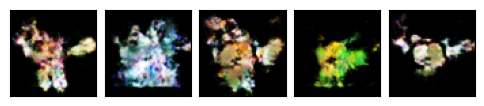

--- EPOCH 77/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.2927101256604167
Generator loss:     7.698045730933376


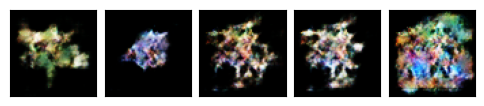

--- EPOCH 78/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.18061888491970368
Generator loss:     6.924993909638504


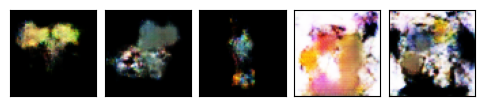

--- EPOCH 79/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.13992655110256424
Generator loss:     7.620018989190288


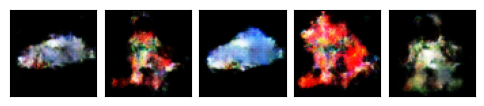

--- EPOCH 80/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.3474285823089638
Generator loss:     7.3269370929605655


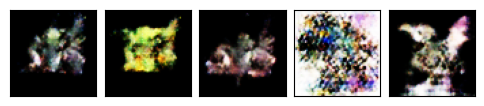

--- EPOCH 81/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.15246563835133767
Generator loss:     7.318917695133165


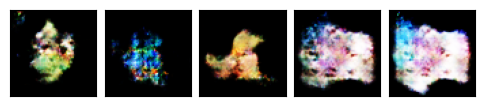

--- EPOCH 82/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.17630220255975065
Generator loss:     8.124094456091694


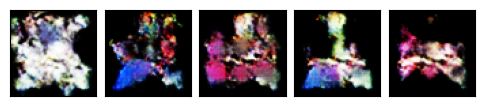

--- EPOCH 83/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.20358749046579175
Generator loss:     7.511840791537844


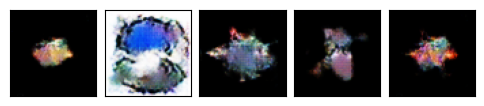

--- EPOCH 84/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.110253539878404
Generator loss:     7.505696792712157


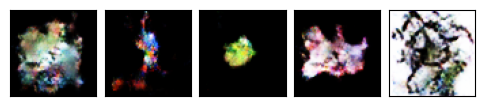

--- EPOCH 85/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.24581308999023904
Generator loss:     8.659640303973493


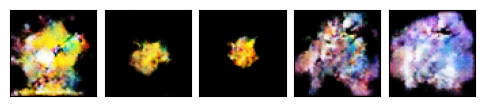

--- EPOCH 86/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.1864052859145677
Generator loss:     7.228336101290823


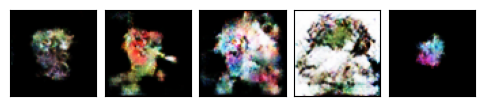

--- EPOCH 87/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.13703187608598977
Generator loss:     8.524912727290186


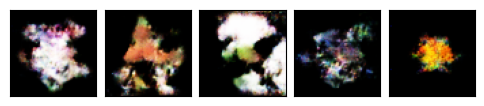

--- EPOCH 88/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.18834513303791656
Generator loss:     8.18998227448299


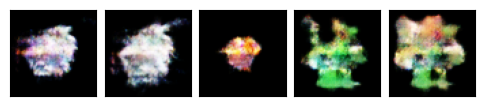

--- EPOCH 89/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.2206977254914484
Generator loss:     8.656434201646125


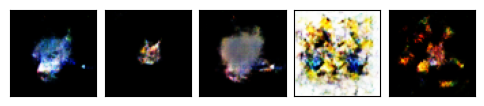

--- EPOCH 90/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.1732230874570622
Generator loss:     8.069164021261807


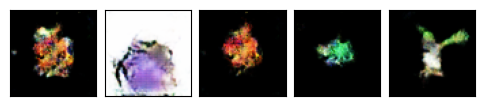

--- EPOCH 91/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.2534586192247854
Generator loss:     7.453232059533569


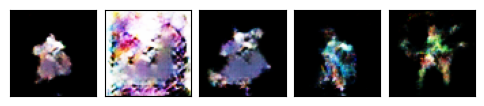

--- EPOCH 92/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.09657077013846786
Generator loss:     8.275486888556644


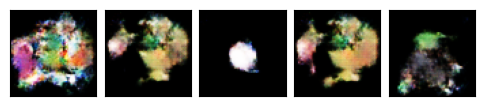

--- EPOCH 93/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.17822868325586977
Generator loss:     8.648354171336383


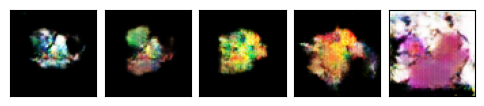

--- EPOCH 94/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.28317865926301344
Generator loss:     8.09107583624193


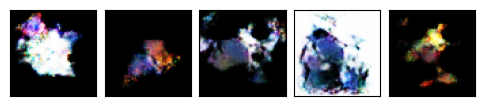

--- EPOCH 95/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.16853111425693007
Generator loss:     8.045200153328906


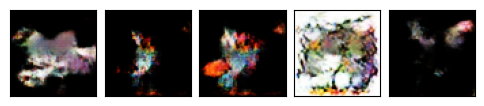

--- EPOCH 96/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.14043559930447874
Generator loss:     7.7039910082159375


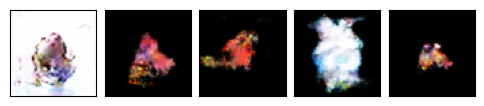

--- EPOCH 97/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.2164127754861082
Generator loss:     8.357984170146372


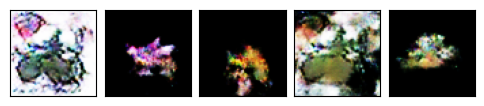

--- EPOCH 98/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.27940331776251737
Generator loss:     8.609742193386472


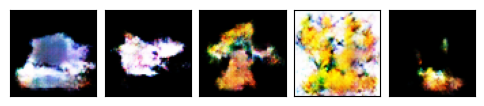

--- EPOCH 99/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.97it/s]
Discriminator loss: 0.20549609756161427
Generator loss:     7.72996968373485


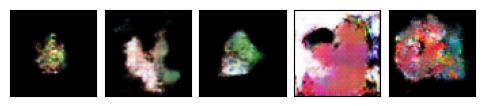

--- EPOCH 100/100 ---
100%|██████████| 87/87 [00:29<00:00,  2.96it/s]
Discriminator loss: 0.15511462569836226
Generator loss:     7.740313677952208


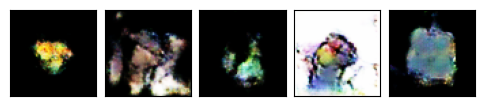

In [27]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


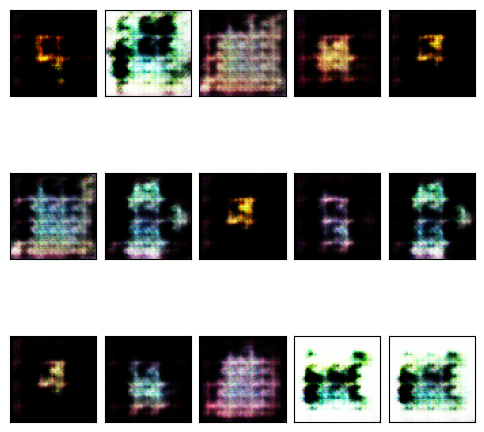

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [14]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [15]:
display_answer(hw3.answers.part2_q1)


**Your answer:**
In our code, the importance of the hyperparameter `x_sigma2` is to scale the reconstruction loss,
This causes that smaller $\sigma$ values increases the weight of the reconstruction error, making the model to try to
imitate the input data better. 
While larger $\sigma$ values increase the weight of the KL divergence, making the model to try to focus on regularizing 
the latent space and thus making smoother latent space helping the model to generalize better


### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [16]:
display_answer(hw3.answers.part2_q2)


**Your answer:**
The VAE loss function is balancing 2 different components, the **reconstruction loss** and the **KL divergence**.

1. **reconstruction loss** - this term is responsible for calculating the difference between the input and the output images
   **KL divergence** -  this term express the difference between the posterior and prior distributions. Making the model
   follow the prior distribution.
2. The KL loss term ensures that the latent space follows the prior distribution which is a normal distribution.
3. This results in a smooth, structured. Helping the model generate new realistic samples
    Without the KL term, the latent space could become irregular and overfit to the training data.


### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [17]:
display_answer(hw3.answers.part2_q3)


**Your answer:**
We start by maximizing the evidence distribution is essential to ensure that the output samples closely resemble the dataset.
This is because when we maximize it, we increase the likelihood that the decoded outputs match the dataset with high probability. 
